# <font color='magenta'>Tratando os dados do Instagram</font>

## <font color='magenta'>1. Importando as bibliotecas</font>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
import os

sns.set_context("talk", font_scale=1)
sns.set_style("darkgrid")
sns.set_palette('tab10')
sns.set_color_codes()

## <font color='magenta'>2. Importando as bases de dados</font>

In [2]:
df_liked_posts = pd.read_json("./dados/instagram/likes/liked_posts.json", encoding='UTF-8')

In [3]:
df_post_comments = pd.read_json("./dados/instagram/comments/post_comments.json", encoding='UTF-8')

In [4]:
df_following = pd.read_json('./dados/instagram/followers_and_following/following.json', encoding='UTF-8')

In [5]:
df_close_friends = pd.read_json('./dados/instagram/followers_and_following/close_friends.json', encoding='UTF-8')

## <font color='magenta'>3. Limpando os dados</font>

### <font color='purple'>3.1. liked_posts.json</font>
**Deste arquivo eu preciso saber os posts que curti e o momento do dia em que curti.     
Então vou descartar metadados da publicação curtida e manter no DataFrame apenas o nome do perfil e     
data/hora da curtida. Preciso extrair as informações de data/hora do timestamp contido na base de dados.**

In [6]:
df_liked_posts.head()

,likes_media_likes
0,"{'title': 'tamisacosta', 'media_list_data': []..."
1,"{'title': 'pe_do_ze', 'media_list_data': [], '..."
2,"{'title': 'sushi_querida', 'media_list_data': ..."
3,"{'title': 'brunamalheiros', 'media_list_data':..."
4,"{'title': 'abaddon_hades', 'media_list_data': ..."


In [7]:
df_liked_posts.tail()

,likes_media_likes
20409,"{'title': 'bbcbrasil', 'media_list_data': [], ..."
20410,"{'title': 'conheciencia', 'media_list_data': [..."
20411,"{'title': 'melhorestirinhaz', 'media_list_data..."
20412,"{'title': 'colecoesfolha', 'media_list_data': ..."
20413,"{'title': 'skoobnews', 'media_list_data': [], ..."


In [8]:
# Separando o timestamp em nova Series
time_of_day = pd.json_normalize(df_liked_posts["likes_media_likes"], "string_list_data")['timestamp']
type(time_of_day)

pandas.core.series.Series

In [9]:
time_of_day.head()

0    1467259886
1    1467208478
2    1467086267
3    1467086231
4    1467086155
Name: timestamp, dtype: int64

In [10]:
# Separando o nome do autor da postagem curtida
post_owner = pd.json_normalize(df_liked_posts["likes_media_likes"])["title"]
type(post_owner)

pandas.core.series.Series

In [11]:
post_owner

0             tamisacosta
1                pe_do_ze
2           sushi_querida
3          brunamalheiros
4           abaddon_hades
               ...       
20409           bbcbrasil
20410        conheciencia
20411    melhorestirinhaz
20412       colecoesfolha
20413           skoobnews
Name: title, Length: 20414, dtype: object

**Uma vez que extraí as informações úteis, preciso concatená-las em um novo DataFrame:**

In [12]:
data = {
    'post_owner': post_owner,
    'time_of_day': time_of_day 
}

# Concatenando as informações do autor do post e período do dia
df_likes = pd.concat(data, axis = 1)

type(df_likes)

pandas.core.frame.DataFrame

In [13]:
df_likes.head()

,post_owner,time_of_day
0,tamisacosta,1467259886
1,pe_do_ze,1467208478
2,sushi_querida,1467086267
3,brunamalheiros,1467086231
4,abaddon_hades,1467086155


**Verificando o tamanho do DataFrame:**

In [14]:
df_likes.shape

(20414, 2)

**Preciso checar se os tipos de dados de cada coluna permite a manipulação que pretendo realizar     
e se há dados nulos:**

In [15]:
# Informações sobre os dados:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   post_owner   20414 non-null  object
 1   time_of_day  20414 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 319.1+ KB


**Vejo que não há dados nulos e vou seguir com a converteção do tipo de dado da     
coluna 'time' de timestamp -> para datetime:**

In [16]:
df_likes['time_of_day'] = pd.to_datetime(df_likes['time_of_day'], unit='s')

In [17]:
# Confirmando se os dados foram convertidos para o tipo datetime:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   post_owner   20414 non-null  object        
 1   time_of_day  20414 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 319.1+ KB


**Agora vou separar algumas informações contidas no timestamp e criar novas colunas     
com ano, mês, dia do mês, dia da semana, data e hora:**

In [18]:
# Ano
df_likes['year'] = df_likes['time_of_day'].dt.year

# Mês
df_likes['month'] = df_likes['time_of_day'].dt.month_name()

# Dia do mês
df_likes['day'] = df_likes['time_of_day'].dt.day

# Dia da semana
df_likes['day_of_week'] = df_likes['time_of_day'].dt.day_name()

# Data
df_likes['date'] = df_likes['time_of_day'].dt.date

# Hora
df_likes['hour'] = df_likes['time_of_day'].dt.hour

In [19]:
df_likes.head()

,post_owner,time_of_day,year,month,day,day_of_week,date,hour
0,tamisacosta,2016-06-30 04:11:26,2016,June,30,Thursday,2016-06-30,4
1,pe_do_ze,2016-06-29 13:54:38,2016,June,29,Wednesday,2016-06-29,13
2,sushi_querida,2016-06-28 03:57:47,2016,June,28,Tuesday,2016-06-28,3
3,brunamalheiros,2016-06-28 03:57:11,2016,June,28,Tuesday,2016-06-28,3
4,abaddon_hades,2016-06-28 03:55:55,2016,June,28,Tuesday,2016-06-28,3


**Agora vou criar colunas específicas para o momento do dia, exemplo:       
1.Início da manhã,    
2.Manhã,     
3.Tarde,         
4.Noite,    
5.Final da Noite e     
6.Madrugada**    

In [20]:
# Criando uma função e estabelecendo as faixas de horário que pretendo segmentar:
def segmenting_day(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Afternoon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [21]:
# Criando uma coluna com a parte do dia e aplicando a função à coluna de horário:
df_likes['part_of_day'] = df_likes['hour'].apply(segmenting_day)

In [22]:
# Verificando se as faixas de horário estão segmentadas:
df_likes.head(15)

,post_owner,time_of_day,year,month,day,day_of_week,date,hour,part_of_day
0,tamisacosta,2016-06-30 04:11:26,2016,June,30,Thursday,2016-06-30,4,Late Night
1,pe_do_ze,2016-06-29 13:54:38,2016,June,29,Wednesday,2016-06-29,13,Afternoon
2,sushi_querida,2016-06-28 03:57:47,2016,June,28,Tuesday,2016-06-28,3,Late Night
3,brunamalheiros,2016-06-28 03:57:11,2016,June,28,Tuesday,2016-06-28,3,Late Night
4,abaddon_hades,2016-06-28 03:55:55,2016,June,28,Tuesday,2016-06-28,3,Late Night
5,abaddon_hades,2016-06-28 03:53:56,2016,June,28,Tuesday,2016-06-28,3,Late Night
6,ncwintersart,2016-06-28 03:50:57,2016,June,28,Tuesday,2016-06-28,3,Late Night
7,pitty,2016-06-28 03:20:18,2016,June,28,Tuesday,2016-06-28,3,Late Night
8,yuridomeniconi,2016-06-26 05:11:50,2016,June,26,Sunday,2016-06-26,5,Early Morning
9,wildlife_animalslife,2016-06-23 06:55:14,2016,June,23,Thursday,2016-06-23,6,Early Morning


### <font color='purple'>3.1.1. Salvando os dados tratados</font>

In [23]:
#df_likes.to_csv('./dados_tratados/instagram/likes.csv', index = None)

### <font color='purple'>3.2. post_comments.json</font>
**Deste arquivo eu preciso saber os posts que comentei e o momento do dia em que o fiz.     
Vou descartar metadados da publicação e manter no DataFrame apenas o nome do perfil e     
data/hora do comentário. Preciso extrair as informações de data/hora do timestamp contido na base de dados.**

In [24]:
df_post_comments.head()

,comments_media_comments
0,"{'title': '__ch3ll__', 'media_list_data': [], ..."
1,"{'title': '__ch3ll__', 'media_list_data': [], ..."
2,"{'title': 'vittorfernando', 'media_list_data':..."
3,"{'title': 'fotochaaat', 'media_list_data': [],..."
4,"{'title': 'prof.danielgontijo', 'media_list_da..."


In [25]:
# Separando o timestamp em nova Series
time_of_day = pd.json_normalize(df_post_comments["comments_media_comments"], "string_list_data")['timestamp']
type(time_of_day)

pandas.core.series.Series

In [26]:
time_of_day.head()

0    1626653508
1    1626631356
2    1626537541
3    1626484050
4    1626448718
Name: timestamp, dtype: int64

In [27]:
# Separando o nome do autor da postagem comentada
post_owner = pd.json_normalize(df_post_comments["comments_media_comments"])["title"]
type(post_owner)

pandas.core.series.Series

In [28]:
post_owner

0                __ch3ll__
1                __ch3ll__
2           vittorfernando
3               fotochaaat
4       prof.danielgontijo
               ...        
1175                bianca
1176        brunamalheiros
1177                dailus
1178          partiurecife
1179        deyvisonfsilva
Name: title, Length: 1180, dtype: object

**Uma vez que extraí as informações úteis, preciso concatená-las em um novo DataFrame:**

In [29]:
data = {
    'post_owner': post_owner,
    'time_of_day': time_of_day 
}

# Concatenando as informações do autor do post e período do dia
df_comments = pd.concat(data, axis = 1)

type(df_comments)

pandas.core.frame.DataFrame

In [30]:
df_comments.head()

,post_owner,time_of_day
0,__ch3ll__,1626653508
1,__ch3ll__,1626631356
2,vittorfernando,1626537541
3,fotochaaat,1626484050
4,prof.danielgontijo,1626448718


**Verificando o tamanho do DataFrame:**

In [31]:
df_comments.shape

(1180, 2)

**Preciso checar se os tipos de dados de cada coluna permite a manipulação que pretendo realizar
e se há dados nulos:**

In [32]:
# Informações sobre os dados:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   post_owner   1180 non-null   object
 1   time_of_day  1180 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.6+ KB


**Vejo que não há dados nulos e vou seguir com a conversão do tipo de dado da     
coluna 'time_of_day_media' de timestamp -> para datetime:**

In [33]:
df_comments['time_of_day'] = pd.to_datetime(df_comments['time_of_day'], unit='s')

In [34]:
# Confirmando se os dados foram convertidos para o tipo datetime:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   post_owner   1180 non-null   object        
 1   time_of_day  1180 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 18.6+ KB


**Agora vou separar algumas informações contidas no timestamp e criar novas colunas      
com ano, mês, dia do mês, dia da semana, data e hora:**

In [35]:
# Ano
df_comments['year'] = df_comments['time_of_day'].dt.year

# Mês
df_comments['month'] = df_comments['time_of_day'].dt.month_name()

# Dia do mês
df_comments['day'] = df_comments['time_of_day'].dt.day

# Dia da semana
df_comments['day_week'] = df_comments['time_of_day'].dt.day_name()

# Data
df_comments['date'] = df_comments['time_of_day'].dt.date

# Hora
df_comments['hour'] = df_comments['time_of_day'].dt.hour

df_comments.head()

,post_owner,time_of_day,year,month,day,day_week,date,hour
0,__ch3ll__,2021-07-19 00:11:48,2021,July,19,Monday,2021-07-19,0
1,__ch3ll__,2021-07-18 18:02:36,2021,July,18,Sunday,2021-07-18,18
2,vittorfernando,2021-07-17 15:59:01,2021,July,17,Saturday,2021-07-17,15
3,fotochaaat,2021-07-17 01:07:30,2021,July,17,Saturday,2021-07-17,1
4,prof.danielgontijo,2021-07-16 15:18:38,2021,July,16,Friday,2021-07-16,15


**Agora vou criar colunas específicas para o momento do dia, exemplo:     
1.Início da manhã,     
2.Manhã,     
3.Tarde,     
4.Noite,    
5.Final da Noite e    
6.Madrugada**   

In [36]:
# Criando uma coluna com a parte do dia e aplicando a função segmenting_day() à coluna de horário:
df_comments['part_of_day'] = df_comments['hour'].apply(segmenting_day)

In [37]:
# Verificando se as faixas de horário estão segmentadas:
df_comments.head(15)

,post_owner,time_of_day,year,month,day,day_week,date,hour,part_of_day
0,__ch3ll__,2021-07-19 00:11:48,2021,July,19,Monday,2021-07-19,0,Late Night
1,__ch3ll__,2021-07-18 18:02:36,2021,July,18,Sunday,2021-07-18,18,Evening
2,vittorfernando,2021-07-17 15:59:01,2021,July,17,Saturday,2021-07-17,15,Afternoon
3,fotochaaat,2021-07-17 01:07:30,2021,July,17,Saturday,2021-07-17,1,Late Night
4,prof.danielgontijo,2021-07-16 15:18:38,2021,July,16,Friday,2021-07-16,15,Afternoon
5,sebastiao.salgados,2021-07-16 14:07:26,2021,July,16,Friday,2021-07-16,14,Afternoon
6,manoel_uchoa,2021-07-15 14:19:33,2021,July,15,Thursday,2021-07-15,14,Afternoon
7,filoeliteratu,2021-07-15 13:52:04,2021,July,15,Thursday,2021-07-15,13,Afternoon
8,sebastiao.salgados,2021-07-15 13:45:02,2021,July,15,Thursday,2021-07-15,13,Afternoon
9,semdeuses,2021-07-14 15:26:35,2021,July,14,Wednesday,2021-07-14,15,Afternoon


### <font color='purple'>3.2.1. Salvando os dados tratados</font>

In [73]:
#df_comments.to_csv('./dados_tratados/instagram/comments.csv', index = None)

In [74]:
df_comments = pd.read_csv("./dados_tratados/instagram/comments.csv")
df_comments.head()

,post_owner,time_of_day,year,month,day,day_week,date,hour,part_of_day
0,__ch3ll__,2021-07-19 00:11:48,2021,July,19,Monday,2021-07-19,0,Late Night
1,__ch3ll__,2021-07-18 18:02:36,2021,July,18,Sunday,2021-07-18,18,Evening
2,vittorfernando,2021-07-17 15:59:01,2021,July,17,Saturday,2021-07-17,15,Afternoon
3,fotochaaat,2021-07-17 01:07:30,2021,July,17,Saturday,2021-07-17,1,Late Night
4,prof.danielgontijo,2021-07-16 15:18:38,2021,July,16,Friday,2021-07-16,15,Afternoon


### <font color='purple'>3.3. following.json</font>
**Deste arquivo eu preciso listar as contas que segui e o momento do dia em que o fiz.     
Vou descartar metadados da publicação e manter no DataFrame apenas o nome do perfil e     
data/hora da ação. Preciso extrair as informações de data/hora do timestamp contido na base de dados.**

In [39]:
df_following.head()

,relationships_following
0,"{'title': '', 'media_list_data': [], 'string_l..."
1,"{'title': '', 'media_list_data': [], 'string_l..."
2,"{'title': '', 'media_list_data': [], 'string_l..."
3,"{'title': '', 'media_list_data': [], 'string_l..."
4,"{'title': '', 'media_list_data': [], 'string_l..."


In [40]:
# Separando o timestamp em nova Series
time_of_day = pd.json_normalize(df_following["relationships_following"], "string_list_data")['timestamp']

type(time_of_day)

pandas.core.series.Series

In [41]:
time_of_day.head()

0    1626750337
1    1626569502
2    1626569364
3    1626568574
4    1626568464
Name: timestamp, dtype: int64

In [42]:
# Separando o nome do autor da postagem comentada
post_owner = pd.json_normalize(df_following["relationships_following"], "string_list_data")['value']

type(post_owner)

pandas.core.series.Series

In [43]:
post_owner

0        hashtagprogramacao
1       paporetonaofazcurva
2                 somosqoda
3            carlos_melo.py
4          inteligencialtda
               ...         
2960             ricardobsa
2961          laisnobregams
2962            igorliravoz
2963     eu_rafaela_andrade
2964             renandozzo
Name: value, Length: 2965, dtype: object

**Uma vez que extraí as informações úteis, preciso concatená-las em um novo DataFrame:**

In [44]:
data = {
    'post_owner': post_owner,
    'time_of_day': time_of_day 
}

df_following = pd.concat(data, axis = 1)

type(df_following)

pandas.core.frame.DataFrame

In [45]:
df_following.head()

,post_owner,time_of_day
0,hashtagprogramacao,1626750337
1,paporetonaofazcurva,1626569502
2,somosqoda,1626569364
3,carlos_melo.py,1626568574
4,inteligencialtda,1626568464


**Verificando o tamanho do DataFrame:**

In [46]:
df_following.shape

(2965, 2)

**Preciso checar se os tipos de dados de cada coluna permite a manipulação que pretendo realizar e se há dados nulos:**

In [47]:
# Informações sobre os dados:
df_following.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   post_owner   2965 non-null   object
 1   time_of_day  2965 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.5+ KB


**Vejo que não há dados nulos e vou seguir com a conversão do tipo de dado da      
coluna 'time_of_day_media' de timestamp -> para datetime:**

In [48]:
df_following['time_of_day'] = pd.to_datetime(df_following['time_of_day'], unit='s')

In [49]:
# Confirmando se os dados foram convertidos para o tipo datetime:
df_following.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   post_owner   2965 non-null   object        
 1   time_of_day  2965 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 46.5+ KB


**Agora vou separar algumas informações contidas no timestamp e criar novas colunas     
com ano, mês, dia do mês, dia da semana, data e hora:**

In [50]:
# Ano
df_following['year'] = df_following['time_of_day'].dt.year

# Mês
df_following['month'] = df_following['time_of_day'].dt.month_name()

# Dia do mês
df_following['day'] = df_following['time_of_day'].dt.day

# Dia da semana
df_following['day_week'] = df_following['time_of_day'].dt.day_name()

# Data
df_following['date'] = df_following['time_of_day'].dt.date

# Hora
df_following['hour'] = df_following['time_of_day'].dt.hour

df_following.head()

,post_owner,time_of_day,year,month,day,day_week,date,hour
0,hashtagprogramacao,2021-07-20 03:05:37,2021,July,20,Tuesday,2021-07-20,3
1,paporetonaofazcurva,2021-07-18 00:51:42,2021,July,18,Sunday,2021-07-18,0
2,somosqoda,2021-07-18 00:49:24,2021,July,18,Sunday,2021-07-18,0
3,carlos_melo.py,2021-07-18 00:36:14,2021,July,18,Sunday,2021-07-18,0
4,inteligencialtda,2021-07-18 00:34:24,2021,July,18,Sunday,2021-07-18,0


**Agora vou criar colunas específicas para o momento do dia, exemplo:     
1.Início da manhã,     
2.Manhã,     
3.Tarde,    
4.Noite,     
5.Final da Noite e     
6.Madrugada**    

In [51]:
# Criando uma coluna com a parte do dia e aplicando a função segmenting_day() à coluna de horário:
df_following['part_of_day'] = df_following['hour'].apply(segmenting_day)

In [52]:
# Verificando se as faixas de horário estão segmentadas:
df_following.head(15)

,post_owner,time_of_day,year,month,day,day_week,date,hour,part_of_day
0,hashtagprogramacao,2021-07-20 03:05:37,2021,July,20,Tuesday,2021-07-20,3,Late Night
1,paporetonaofazcurva,2021-07-18 00:51:42,2021,July,18,Sunday,2021-07-18,0,Late Night
2,somosqoda,2021-07-18 00:49:24,2021,July,18,Sunday,2021-07-18,0,Late Night
3,carlos_melo.py,2021-07-18 00:36:14,2021,July,18,Sunday,2021-07-18,0,Late Night
4,inteligencialtda,2021-07-18 00:34:24,2021,July,18,Sunday,2021-07-18,0,Late Night
5,vilela,2021-07-18 00:34:17,2021,July,18,Sunday,2021-07-18,0,Late Night
6,pedropallotta,2021-07-18 00:34:08,2021,July,18,Sunday,2021-07-18,0,Late Night
7,googlebrasil,2021-07-17 01:36:22,2021,July,17,Saturday,2021-07-17,1,Late Night
8,carmodallavecchia,2021-07-17 01:24:47,2021,July,17,Saturday,2021-07-17,1,Late Night
9,vittorfernando,2021-07-17 01:21:52,2021,July,17,Saturday,2021-07-17,1,Late Night


### <font color='purple'>3.3.1. Salvando os dados tratados</font>

In [53]:
#df_following.to_csv('./dados_tratados/instagram/following.csv', index = None)

### <font color='purple'>3.4. close_friends.json</font>
**Deste arquivo eu vou listar os amigos próximos e o momento do dia em que os incluí na lista.     
Da mesma forma que nos casos anteriores vou descartar metadados da publicação   
e manter no DataFrame apenas o nome do perfil e data/hora da inclusão.     
Preciso extrair as informações de data/hora do timestamp contido na base de dados.**

In [54]:
df_close_friends.head()

,relationships_close_friends
0,"{'title': '', 'media_list_data': [], 'string_l..."
1,"{'title': '', 'media_list_data': [], 'string_l..."
2,"{'title': '', 'media_list_data': [], 'string_l..."
3,"{'title': '', 'media_list_data': [], 'string_l..."
4,"{'title': '', 'media_list_data': [], 'string_l..."


In [55]:
# Separando o timestamp em nova Series
time_of_day = pd.json_normalize(df_close_friends["relationships_close_friends"], "string_list_data")['timestamp']

type(time_of_day)

pandas.core.series.Series

In [56]:
time_of_day.head()

0    1601420019
1    1589809909
2    1585779872
3    1585779673
4    1585779666
Name: timestamp, dtype: int64

In [57]:
# Separando o nome dos amigos próximos
name = pd.json_normalize(df_close_friends["relationships_close_friends"], "string_list_data")['value']

type(name)

pandas.core.series.Series

In [58]:
name

0           caiocportela
1                 saalrf
2           elizabete.ls
3       louise_louisinha
4         monicaalves027
5     casadearthurelucas
6              roh_costa
7         conjecturancas
8               tulio.87
9       victorleandro4.0
10        cleyson.erasmo
11           tamisacosta
12     jonathas_paulo_jp
13           rai_sousajr
14        luccas._.alves
15     sylvesterhenrique
Name: value, dtype: object

**Uma vez que extraí as informações úteis, preciso concatená-las em um novo DataFrame:**

In [59]:
data_cf = {
    'name': name,
    'time_of_day': time_of_day 
}

df_close_friends = pd.concat(data_cf, axis = 1)

type(df_close_friends)

pandas.core.frame.DataFrame

In [60]:
df_close_friends.head()

,name,time_of_day
0,caiocportela,1601420019
1,saalrf,1589809909
2,elizabete.ls,1585779872
3,louise_louisinha,1585779673
4,monicaalves027,1585779666


**Verificando o tamanho do DataFrame:**

In [61]:
df_close_friends.shape

(16, 2)

**Preciso checar se os tipos de dados de cada coluna permite a manipulação     
que pretendo realizar e se há dados nulos:**

In [62]:
# Informações sobre os dados:
df_close_friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         16 non-null     object
 1   time_of_day  16 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 384.0+ bytes


**Vejo que não há dados nulos e vou seguir com a conversão do tipo de dado     
da coluna 'time_of_day' de timestamp -> para datetime:**

In [63]:
df_close_friends['time_of_day'] = pd.to_datetime(df_close_friends['time_of_day'], unit='s')

In [64]:
# Confirmando se os dados foram convertidos para o tipo datetime:
df_close_friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         16 non-null     object        
 1   time_of_day  16 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 384.0+ bytes


**Agora vou separar algumas informações contidas no timestamp e criar novas colunas     
com ano, mês, dia do mês, dia da semana, data e hora:**

In [65]:
# Ano
df_close_friends['year'] = df_close_friends['time_of_day'].dt.year

# Mês
df_close_friends['month'] = df_close_friends['time_of_day'].dt.month_name()

# Dia do mês
df_close_friends['day'] = df_close_friends['time_of_day'].dt.day

# Dia da semana
df_close_friends['day_week'] = df_close_friends['time_of_day'].dt.day_name()

# Data
df_close_friends['date'] = df_close_friends['time_of_day'].dt.date

# Hora
df_close_friends['hour'] = df_close_friends['time_of_day'].dt.hour

df_close_friends.head()

,name,time_of_day,year,month,day,day_week,date,hour
0,caiocportela,2020-09-29 22:53:39,2020,September,29,Tuesday,2020-09-29,22
1,saalrf,2020-05-18 13:51:49,2020,May,18,Monday,2020-05-18,13
2,elizabete.ls,2020-04-01 22:24:32,2020,April,1,Wednesday,2020-04-01,22
3,louise_louisinha,2020-04-01 22:21:13,2020,April,1,Wednesday,2020-04-01,22
4,monicaalves027,2020-04-01 22:21:06,2020,April,1,Wednesday,2020-04-01,22


**Agora vou criar colunas específicas para o momento do dia, exemplo:    
1.Início da manhã,    
2.Manhã,    
3.Tarde,    
4.Noite,    
5.Final da Noite e    
6.Madrugada**    

In [66]:
# Criando uma coluna com a parte do dia e aplicando a função segmenting_day() à coluna de horário:
df_close_friends['part_of_day'] = df_close_friends['hour'].apply(segmenting_day)

In [67]:
# Verificando se as faixas de horário estão segmentadas:
df_close_friends.head(15)

,name,time_of_day,year,month,day,day_week,date,hour,part_of_day
0,caiocportela,2020-09-29 22:53:39,2020,September,29,Tuesday,2020-09-29,22,Night
1,saalrf,2020-05-18 13:51:49,2020,May,18,Monday,2020-05-18,13,Afternoon
2,elizabete.ls,2020-04-01 22:24:32,2020,April,1,Wednesday,2020-04-01,22,Night
3,louise_louisinha,2020-04-01 22:21:13,2020,April,1,Wednesday,2020-04-01,22,Night
4,monicaalves027,2020-04-01 22:21:06,2020,April,1,Wednesday,2020-04-01,22,Night
5,casadearthurelucas,2020-04-01 22:20:55,2020,April,1,Wednesday,2020-04-01,22,Night
6,roh_costa,2020-04-01 22:20:41,2020,April,1,Wednesday,2020-04-01,22,Night
7,conjecturancas,2020-04-01 22:20:32,2020,April,1,Wednesday,2020-04-01,22,Night
8,tulio.87,2020-04-01 22:19:23,2020,April,1,Wednesday,2020-04-01,22,Night
9,victorleandro4.0,2020-03-29 19:54:23,2020,March,29,Sunday,2020-03-29,19,Evening


### <font color='purple'>3.4.1. Salvando os dados tratados</font>

In [68]:
#df_close_friends.to_csv('./dados_tratados/instagram/close_friends.csv', index = None)

## <font color='magenta'>4. Análise Exploratória dos dados do Instagram</font>

### <font color='purple'>4.1. liked_posts.csv</font>

In [69]:
# Importando a base liked_posts.csv
df_likes = pd.read_csv("./dados_tratados/instagram/likes.csv", sep=',', encoding = 'UTF-8')

In [70]:
df_likes.head()

,post_owner,time_of_day,year,month,day,day_of_week,date,hour,part_of_day
0,tamisacosta,2016-06-30 04:11:26,2016,June,30,Thursday,2016-06-30,4,Late Night
1,pe_do_ze,2016-06-29 13:54:38,2016,June,29,Wednesday,2016-06-29,13,Afternoon
2,sushi_querida,2016-06-28 03:57:47,2016,June,28,Tuesday,2016-06-28,3,Late Night
3,brunamalheiros,2016-06-28 03:57:11,2016,June,28,Tuesday,2016-06-28,3,Late Night
4,abaddon_hades,2016-06-28 03:55:55,2016,June,28,Tuesday,2016-06-28,3,Late Night


<AxesSubplot:>

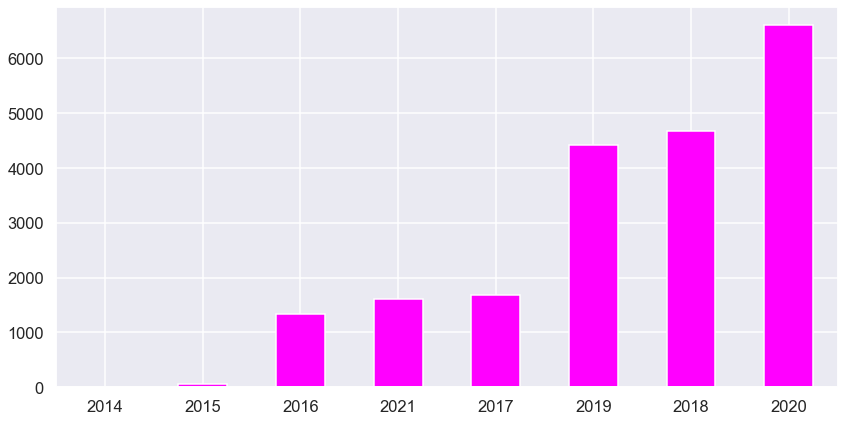

In [71]:
# Likes por ano
df_likes['year'].value_counts().sort_values().plot(kind='bar', color='magenta', figsize=(14,7), rot=0)

<AxesSubplot:>

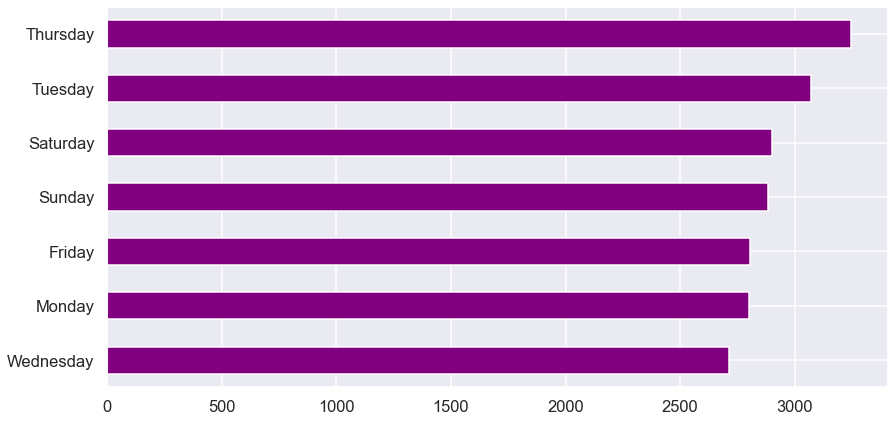

In [72]:
# Likes por dia da semana
df_likes['day_of_week'].value_counts().sort_values().plot(kind='barh', color='purple', figsize=(14,7))

### Obs: A Análise Exploratória completa será realizada no Tableau

## <font color='magenta'>Fim</font>